In [1]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras_contrib.layers import SReLU
from keras.callbacks import BaseLogger, EarlyStopping, ReduceLROnPlateau, TensorBoard
from sklearn.preprocessing import StandardScaler
from sklearn.utils import compute_class_weight
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from scipy import stats
import os
%matplotlib inline

Using TensorFlow backend.


In [18]:
seed = 1
data = pd.read_csv('creditcard.csv')
data.iloc[:, 1:29] = StandardScaler().fit_transform(data.iloc[:, 1:29])
data_matrix = data.as_matrix()
X = data_matrix[:, 1:29]
Y = data_matrix[:, 30]
class_weights = dict(zip([0, 1], compute_class_weight('balanced', [0, 1], Y)))
kfold = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)

In [19]:
# encode class values as integers
encoder = LabelEncoder()
encoded_Y = encoder.fit_transform(Y)
# convert integers to dummy variables (one hot encoding)
dummy_y = np_utils.to_categorical(encoded_Y)

In [20]:
# Define a model generator
def generate_model():
    _model = Sequential()
    _model.add(Dense(15, input_dim=28))
    _model.add(SReLU())
    _model.add(Dropout(0.2))
    _model.add(Dense(2, activation='sigmoid'))
    _model.compile(loss='binary_crossentropy', optimizer='adam')
    return _model

In [21]:
predictions = np.empty([len(Y), kfold.n_splits])

k = 0 
for train, test in kfold.split(X, np.zeros(shape=(X.shape[0], 1))):
    X_train, X_test = X[train], X[test]
    y_train, y_test = dummy_y[train], dummy_y[test]
    # Define model
    model = generate_model()
    # Fit the model
    history = model.fit(X_train, y_train,
                        batch_size=1200,
                        epochs=100,
                        verbose=0,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        class_weight=class_weights)
    # Store the predicted probabilities and iterate k
    pred = model.predict_classes(X_test)
    predictions[test, k] = pred
    k += 1

             precision    recall  f1-score   support

        0.0       1.00      0.99      0.99    284315
        1.0       0.12      0.89      0.22       492

avg / total       1.00      0.99      0.99    284807

Predictions       0     1
Truth                    
0.0          281195  3120
1.0              56   436


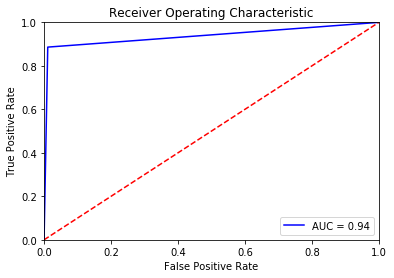

In [15]:
# yhat = np.nanmean(predictions, axis=1).round().astype(int)
# yhat = stats.mode(predictions.T).mode.T[:,0]
yhat = np.max(predictions, axis=1).round().astype(int)

# Performance
print(classification_report(Y, yhat))
print(pd.crosstab(Y, yhat.flatten(), rownames=['Truth'], colnames=['Predictions']))

fpr, tpr, thresholds = roc_curve(Y, yhat)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.,1.])
plt.ylim([0.,1.])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

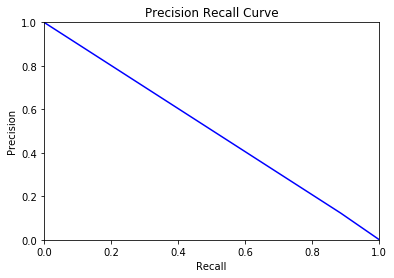

In [10]:
precision, recall, thresholds = precision_recall_curve(Y, yhat)
plt.clf()
plt.title('Precision Recall Curve')
plt.plot(recall, precision, 'b')
plt.xlim([0.,1.])
plt.ylim([0.,1.])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [32]:
predictions = np.empty([len(Y), kfold.n_splits])

k = 0 
for train, test in kfold.split(X, np.zeros(shape=(X.shape[0], 1))):
    X_train, X_test = X[train], X[test]
    y_train, y_test = dummy_y[train], dummy_y[test]
    # Define model
    model = generate_model()
    # Fit the model
    history = model.fit(X_train, y_train,
                        batch_size=1200,
                        epochs=100,
                        verbose=0,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        class_weight=class_weights)
    # Store the predicted probabilities and iterate k
    pred = model.predict_proba(X_test)[:,1]
    predictions[test, k] = pred
    k += 1

             precision    recall  f1-score   support

       -5.0       0.00      0.00      0.00         0
       -4.0       0.00      0.00      0.00         0
       -3.0       0.00      0.00      0.00         0
       -2.0       0.00      0.00      0.00         0
       -1.0       0.00      0.00      0.00         0
        0.0       1.00      0.98      0.99    284315
        1.0       0.00      0.04      0.01       492
        2.0       0.00      0.00      0.00         0
        3.0       0.00      0.00      0.00         0
        4.0       0.00      0.00      0.00         0

avg / total       1.00      0.98      0.99    284807

Predictions  -5  -4  -3  -2    -1       0     1    2   3   4
Truth                                                       
0.0           3   4  16  22  1243  277857  4914  241  12   3
1.0           0   0   0   0     1     470    20    1   0   0


/usr/local/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


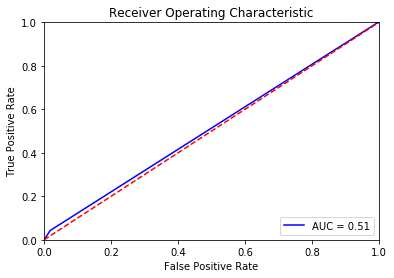

In [34]:
yhat = np.nanmean(predictions, axis=1).round().astype(int)
# yhat = stats.mode(predictions.T).mode.T[:,0]
# yhat = np.max(predictions, axis=1).round().astype(int)

# Performance
print(classification_report(Y, yhat))
print(pd.crosstab(Y, yhat.flatten(), rownames=['Truth'], colnames=['Predictions']))

fpr, tpr, thresholds = roc_curve(Y, yhat)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.,1.])
plt.ylim([0.,1.])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [14]:
import numpy as np 
from sklearn.model_selection import KFold,StratifiedKFold

X=np.array([
    [1,2,3,4],
    [11,12,13,14],
    [21,22,23,24],
    [31,32,33,34],
    [41,42,43,44],
    [51,52,53,54],
    [61,62,63,64],
    [71,72,73,74]
])

y=np.array([1,1,0,0,1,1,0,0])
#n_folds这个参数没有，引入的包不同，
floder = KFold(n_splits=3,random_state=0,shuffle=False)
sfolder = StratifiedKFold(n_splits=4,random_state=0,shuffle=False)

for train, test in sfolder.split(X,y):
    print('Train: %s | test: %s' % (train, test))
    print(" ")

print("-----")
for train, test in floder.split(X,y):
    print('Train: %s | test: %s' % (train, test))
    print(" ")

Train: [1 3 4 5 6 7] | test: [0 2]
 
Train: [0 2 4 5 6 7] | test: [1 3]
 
Train: [0 1 2 3 5 7] | test: [4 6]
 
Train: [0 1 2 3 4 6] | test: [5 7]
 
-----
Train: [3 4 5 6 7] | test: [0 1 2]
 
Train: [0 1 2 6 7] | test: [3 4 5]
 
Train: [0 1 2 3 4 5] | test: [6 7]
 


In [80]:
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [3, 7], [9, 4]])
# y = np.array([0, 0, 1, 1, 0, 1]) # <<< works
y = X # does not work if passed into `.split`
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=36851234)
for train_index, test_index in rskf.split(X, np.zeros(shape=(X.shape[0], 1))):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [1 3 4 5] TEST: [0 2]
TRAIN: [0 1 2 3] TEST: [4 5]
TRAIN: [0 2 4 5] TEST: [1 3]
TRAIN: [1 3 4 5] TEST: [0 2]
TRAIN: [0 2 3 4] TEST: [1 5]
TRAIN: [0 1 2 5] TEST: [3 4]
TRAIN: [0 1 3 4] TEST: [2 5]
TRAIN: [0 1 2 5] TEST: [3 4]
TRAIN: [2 3 4 5] TEST: [0 1]


In [153]:
import numpy as np
from scipy import stats

a = np.array([[1, 3, 4, 2, 2, 7],
              [5, 2, 2, 1, 4, 1],
              [3, 3, 2, 2, 1, 1]])

m = stats.mode(a)
print(m.mode)

[[1 3 2 2 1 1]]
